<a href="https://colab.research.google.com/github/filizolalab/CADD2021/blob/main/BSR3101_Tutorial_Predicting_binding_from_3D_grid_featurization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Modeling Protein-Ligand Interactions with Atomic Convolutions


This tutorial is based on examples from [Nathan C. Frey](https://ncfrey.github.io/) and [Bharath Ramsundar](https://rbharath.github.io/) and Deepchem tutorials and examples.


In [ ]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

     |████████████████████████████████| 609 kB 4.0 MB/s 
     |████████████████████████████████| 20.6 MB 1.3 MB/s 


'2.6.0.dev'

In [ ]:
#!pip -q install py3Dmol 2>&1 1>/dev/null
#!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
#!pip install biopandas 2>&1 1>/dev/null
# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm Miniconda3-latest-Linux-x86_64.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer 2>&1 1>/dev/null

#!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
#!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null


In [ ]:
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import openmm as mm
import pdbfixer

In [ ]:
# !pip install mdtraj

In [ ]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from rdkit import Chem
from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

### Getting protein-ligand data


In [ ]:
#f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
#f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
#max_num_neighbors = 12  # maximum number of spatial neighbors for an atom
#
#acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
#                      frag2_num_atoms=f2_num_atoms,
#                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
#                      max_num_neighbors=max_num_neighbors,
#                      neighbor_cutoff=4)

In [ ]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=dc.feat.SplifFingerprint(size=500),
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

CPU times: user 2min 27s, sys: 23.7 s, total: 2min 50s
Wall time: 2min 55s


In [ ]:
datasets[0].ids

array(['3su5', '2j62', '3uex', '2vl4', '2xb8', '2wca', '2p4y', '2obf',
       '3ueu', '2zx6', '2xdl', '3ag9', '4de2', '1u1b', '3vd4', '2x8z',
       '1lor', '2pq9', '3su3', '3myg', '2y5h', '1bcu', '3udh', '1zea',
       '1p1q', '1o3f', '1kel', '2xhm', '3gcs', '2d1o', '3k5v', '2zxd',
       '2jdu', '1z95', '3dd0', '3f3a', '2qft', '2weg', '3imc', '2r23',
       '1h23', '3kv2', '2iwx', '3f3c', '3gbb', '3mss', '3l4w', '2v7a',
       '1n2v', '2zcr', '3gy4', '3su2', '2xnb', '3f17', '1hfs', '1sqa',
       '4tmn', '2v00', '2jdy', '3l4u', '3huc', '3d4z', '3b3w', '2zcq',
       '4g8m', '2xys', '2g70', '3f80', '4de1', '2yki', '2d3u', '1lbk',
       '1q8t', '2x0y', '1mq6', '3lka', '3kgp', '1w4o', '1lol', '3ge7',
       '1e66', '2vvn', '10gs', '2xbv', '3g0w', '3nox', '3n7a', '3b3s',
       '4dew', '1w3l', '3ao4', '2vo5', '1o5b', '3gnw', '3cj2', '3ejr',
       '3pxf', '4djv', '2qmj', '1f8c', '3ov1', '3f3e', '2cet', '1gpk',
       '3fv1', '1a30', '1uto', '4des', '3jvs', '3g2z', '1u33', '2x97',
      

In [ ]:
datasets[0].X[0].shape

(1500,)

`load_pdbbind` allows us to specify if we want to use the entire protein or only the binding pocket (`pocket=True`) for featurization. Using only the pocket saves memory and speeds up the featurization. We can also use the "core" dataset of ~200 high-quality complexes for rapidly testing our model, or the larger "refined" set of nearly 5000 complexes for more datapoints and more robust training/validation. On Colab, it takes only a minute to featurize the core PDBbind set! This is pretty incredible, and it means you can quickly experiment with different featurizations and model architectures.

In [ ]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=dc.feat.SplifVoxelizer(),
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')


TypeError: ignored

In [ ]:
datasets[0].X.shape

(154, 16, 16, 16, 24)

In [ ]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=dc.feat.ContactCircularFingerprint(),
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

CPU times: user 34.4 s, sys: 24.1 s, total: 58.5 s
Wall time: 1min 4s


In [ ]:
datasets[0].X.shape

(154, 16)

In [ ]:
#f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
#f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
#max_num_neighbors = 12  # maximum number of spatial neighbors for an atom
#
#acf = AtomicConvFeaturizer(
#    frag1_num_atoms=f1_num_atoms,
#    frag2_num_atoms=f2_num_atoms,
#    complex_num_atoms=f1_num_atoms+f2_num_atoms,
#   max_num_neighbors=max_num_neighbors,
#    neighbor_cutoff=4)

In [ ]:
#grid_featurizer = deepchem.feat.RdkitGridFeaturizer(voxel_width=2, feature_types=['hbond','salt_bridge'], sanitize=True, flatten=True)

In [ ]:
#%%time
#tasks, datasets, transformers = load_pdbbind(featurizer=grid_featurizer,
#                                             save_dir='.',
#                                             data_dir='.',
#                                             pocket=True,
#                                             reload=False,
#                                             set_name='core')

In [ ]:
train, val, test = datasets

### Training the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
sklearn_model = RandomForestRegressor(n_estimators=30)
model=dc.models.SklearnModel(sklearn_model)

In [ ]:
model.fit(train)

In [ ]:
metric=dc.metrics.Metric(dc.metrics.pearson_r2_score)
print(f'train r2: {model.evaluate(train,[metric],transformers)}')
print(f'test r2: {model.evaluate(test,[metric],transformers)}')


train r2: {'pearson_r2_score': 0.9383895555742319}
test r2: {'pearson_r2_score': 0.3764357662632012}


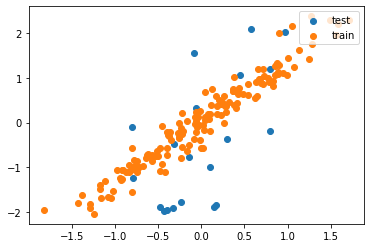

In [ ]:


f, ax = plt.subplots()
ax.scatter(model.predict(test), test.y, label='test')
ax.scatter(model.predict(train), train.y, label='train')
plt.legend(loc='upper right');


In [ ]:
train

<DiskDataset X.shape: (154, 1500), y.shape: (154,), w.shape: (154,), ids: ['3su5' '2j62' '3uex' ... '2hb1' '1vso' '2gss'], task_names: [0]>

In [ ]:
n_features=train.X.shape[1]
n_features
model2=dc.models.MultitaskRegressor(
    n_tasks=1,
    n_features=n_features,
    layer_sizes=[2000,1000],
    dropouts=0.5,
    learning_rate=0.0003)

In [ ]:
model2.fit(train, nb_epoch=300)

0.05380191326141357

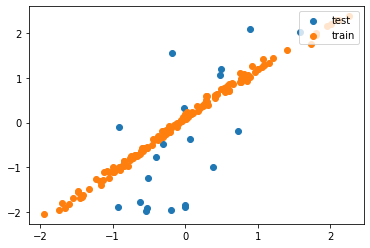

In [ ]:

f, ax = plt.subplots()
ax.scatter(model2.predict(test), test.y, label='test')
ax.scatter(model2.predict(train), train.y, label='train')
plt.legend(loc='upper right');

In [ ]:
metric=dc.metrics.Metric(dc.metrics.pearson_r2_score)
print(f'train r2: {model2.evaluate(train,[metric],transformers)}')
print(f'test r2: {model2.evaluate(test,[metric],transformers)}')


train r2: {'pearson_r2_score': 0.9941549609888485}
test r2: {'pearson_r2_score': 0.4627445879043084}


Now that we've got our dataset, let's go ahead and initialize an `AtomicConvModel` to train. Keep the input parameters the same as those used in `AtomicConvFeaturizer`, or else we'll get errors. `layer_sizes` controls the number of layers and the size of each dense layer in the network. We choose these hyperparameters to be the same as those used in the [original paper](https://arxiv.org/pdf/1703.10603.pdf).

In [ ]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )

In [ ]:
losses, val_losses = [], []

In [ ]:
%%time
max_epochs = 50

for epoch in range(max_epochs):
  loss = acm.fit(train, nb_epoch=1, max_checkpoints_to_keep=1, all_losses=losses)
  metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
  val_losses.append(acm.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss

CPU times: user 9min 5s, sys: 1min 58s, total: 11min 4s
Wall time: 11min 54s


The loss curves are not exactly smooth, which is unsurprising because we are using 154 training and 19 validation datapoints. Increasing the dataset size may help with this, but will also require greater computational resources.

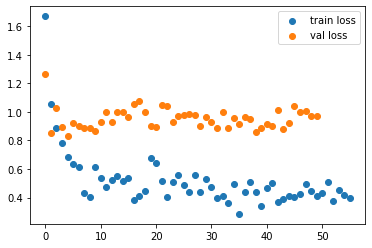

In [ ]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

The [ACNN paper](https://arxiv.org/pdf/1703.10603.pdf) showed a Pearson $R^2$ score of 0.912 and 0.448 for a random 80/20 split of the PDBbind core train/test sets. Here, we've used an 80/10/10 training/validation/test split and achieved similar performance for the training set (0.943). We can see from the performance on the training, validation, and test sets (and from the results in the paper) that the ACNN can learn chemical interactions from small training datasets, but struggles to generalize. Still, it is pretty amazing that we can train an `AtomicConvModel` with only a few lines of code and start predicting binding affinities!  
From here, you can experiment with different hyperparameters, more challenging splits, and the "refined" set of PDBbind to see if you can reduce overfitting and come up with a more robust model.

In [ ]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
  print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9437584772241725}
val {'pearson_r2_score': 0.16399398585969166}
test {'pearson_r2_score': 0.25027177101277903}


### Further reading
We have explored the ACNN architecture and used the PDBbind dataset to train an ACNN to predict protein-ligand binding energies. For more information, read the original paper that introduced ACNNs: Gomes, Joseph, et al. "Atomic convolutional networks for predicting protein-ligand binding affinity." [arXiv preprint arXiv:1703.10603](https://arxiv.org/abs/1703.10603) (2017). There are many other methods and papers on predicting binding affinities. Here are a few interesting ones to check out: predictions using [only ligands or proteins](https://www.frontiersin.org/articles/10.3389/fphar.2020.00069/full), [molecular docking with deep learning](https://chemrxiv.org/articles/preprint/GNINA_1_0_Molecular_Docking_with_Deep_Learning/13578140), and [AtomNet](https://arxiv.org/abs/1510.02855).

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!